# Project: PFR  reactor design

In this project you will design a PFR (plug flow reactor) optimized to produce a given particle number distribution. First we introduce the governing equations.

The general dynamic equation which incorporates convective diffusion is given by (Friedlander, 2000; p. 306-307):

$$
\frac{\partial n_{k}}{\partial t}+\nabla \cdot n_{k} \mathbf{v}=\nabla \cdot D \nabla n_{k}+\left[\frac{\partial n_{k}}{\partial t}\right]_{\text {growth }}+\left[\frac{\partial n_{k}}{\partial t}\right]_{c_{k} \phi}-\nabla \cdot \mathbf{c} n_{k}
$$

The mass balance in the PFR with a volume $B$ is given by

$$
\frac {d F_N}{dV} = r_N
$$

And the Smoluchowski type aggregation model:

$$
\begin{split}
& \frac{\partial n(v_p,t)}{\partial t} =
\frac{1}{2}\int_0^{v_p} \beta(\tilde{v_p},v_p-\tilde{v_p}) \, n(\tilde{v_p},t) \, n(v_p-\tilde{v_p},t) \, d\tilde{v_p} 
- \int_0^{\infty} \beta(v_p,\tilde{v_p}) \, n(v_p,t) \, n(\tilde{v_p},t) \, d\tilde{v_p} 
\end{split}
$$



providing:
$$
\frac {d F_N}{dV} = \frac{\partial n(v_p,t)}{\partial t} 
$$

where $F_N$ is a vector of the number flowrates of particles of each volume.


Task 1 (20%): For a residence time of $\tau = B/Q = 2$ s, and a reactor of size $B = 1$ m$^3$, write a simulation of a PFR reactor with an initial input steam that has the following variables:

- $F_{0} = 10^{17}$ $(\#$ particles s$^{-1}$)
- $n_{0}= F_{0} \delta\left(v-v_{0}\right)$ (monodisperse as above)
- $Q = 0.5~($m$^{3}$s$^{-1}$)

For the particle volumes use
- $d_p$ (min) $= 0.5 \times 10^{-9}$ (m)
- $d_p$ (max) $= 1000 \times 10^{-9}$ (m)




Task 2 (20%): For a conservation of mass validation comparing the mass flow compute the volume of the particles entering and leaving the reactor.

Task 3 (60%): Add in a recycle stream to your PFR reactor. Find the recyle ratio $R$ that produces the number average particle distribution of $d_{p, avg} = 3.5 \times 10^{-9}$. 

<img src="PFR.svg">

The number average particle distribution can be found using the following function from a vector $n$:

```python
# Function for computing number average particle distribution
def dp_avg(n, dp):
    return np.sum(n * dp) / np.sum(n)
```

Task 4 (30%): Use the solution from CSTR reactor below and compare the performance of the CSTR with the PFR reactor by sizing the materials for the same flowrates.

Note that the marks total to $130$ points


In [33]:
# imports and variables

import numpy as np
from matplotlib import pyplot as plt
t_total = 5e-0                           # [s], change from 2e-4 to 2e-0 or any 
                                         # other number   
nt = 1000                                # number of iteration steps 
dt = t_total / nt                        # [s], small time step during the interation
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi/6 * (dp_min)**3           # [m^3]
vp_max = np.pi/6 * (dp_max)**3           # [m^3]
# Initialization
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)
vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 
    
n = np.zeros((vp_num))
k_B = 1.380649e-23                       # [J / K = N m / K = kg m^2 / (s^2 * K)]
mu = 17.2e-6                             # dynamische Viskosität Luft [Pa*s = N * s /m^2 = kg / ( m * s)] 
T = 293                                  # [K]

beta_pre = (2*k_B*T)/(3*mu)              # [kg m^2 *K *m * s/ (s^2 * K * kg) = m^3/s]


beta_n = np.zeros((vp_num, vp_num))
for i in range(vp_num): 
    for j in range(vp_num): 
        beta_n[i,j] = beta_pre * (1/vp[i]**(1/3) + 1/vp[j]**(1/3)) *(vp[i]**(1/3) + vp[j]**(1/3))
        # [m^3 /s * 1/m * m = m^3/s]
        
# Initial conditions
n_0 = np.zeros((vp_num))
start_bin = 1                 # this is an easy way to select a starting size
n_0[start_bin] = 1e17         # [#/m^3]
n = n_0.copy()                # copy the initial condition to our interation array 
Q = 1
B = 1
N_0 = 1e17

n_zeit = np.zeros((nt))
n_formed = np.zeros((vp_num))

# Main solver loop
nn = np.empty_like(n)
n_formed = np.empty_like(n)
n_in = np.empty_like(n)
n_in[1] = N_0
for t in range(nt - 1):
    nn = n.copy()
    for i in range(1, vp_num, 1):
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        for j in range(0, i - 1, 1):
            sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
        for j in range(0, i - 0, 1):    
            sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
        for j in range(i, vp_num - 1, 1): 
            sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
        n_formed[i] = nn[i] + dt * ( \
                             nn[i-1] * sum1[i] + \
                             1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - \
                             nn[i] * sum2[i] - \
                             nn[i] * sum3[i]     
                             )
        n[i] = nn[i] + dt * (B * n_formed[i] + Q * n_in[i] - nn[i] * Q)

            

def fun_q(v): 
    return A * v **(1/3)

def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp((3/2.0) * (vp_min**(2/3.0) - v**(2/3.0))/(A * tau)) * (N_0 / tau)

tau = B/Q  # Verweilzeit
A = 1e-1
q = np.array(fun_q(vp))
n_an = np.zeros(vp_num)

for j in range(1, vp_num, 1):
    n_an[j] = an_n(vp[j])

<IPython.core.display.Javascript object>


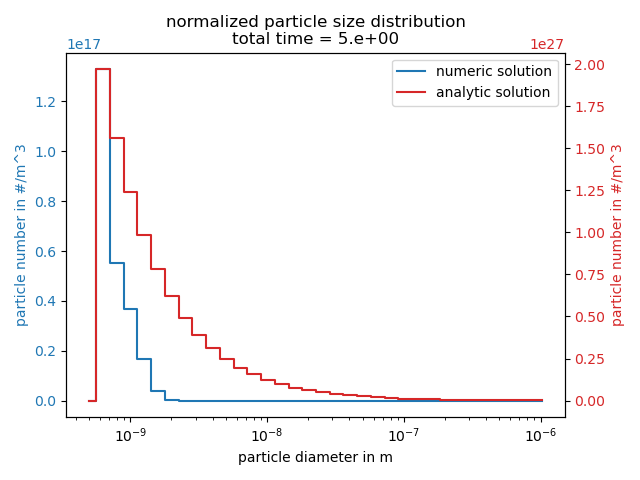

In [34]:
%matplotlib notebook
dp_start = np.zeros((vp_num))
dp_end = np.zeros((vp_num))
dp_start = (6/np.pi * vp[start_bin])**(1/3)
dp_end = (6/np.pi * vp)**(1/3)

fig, ax1 = plt.subplots()
color1 = "tab:blue"
ax1.semilogx(dp_end, n, drawstyle="steps-mid", \
             label="numeric solution", color = color1) 
ax1.set_ylabel("particle number in #/m^3", color = color1)
ax1.tick_params(axis="y", labelcolor = color1)
title_string = "normalized particle size distribution" + "\n" + \
    "total time = " + \
    str(np.format_float_scientific(t_total, precision=0))
ax1.set_title(title_string)
ax1.set_xlabel("particle diameter in m")

color2 = "tab:red"
ax2 = ax1.twinx() 
ax2.semilogx(dp_end, n_an, drawstyle="steps-mid", \
             label="analytic solution", color = color2) 
ax2.set_ylabel("particle number in #/m^3", color = color2)
ax2.tick_params(axis="y", labelcolor = color2)
#ax2.set_ylim(1.2e24,1.22e24)


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()
